
# Linear Models and Regularization Methods

<a target="_blank" href="https://colab.research.google.com/github/intro-stat-learning/ISLP_labs/blob/v2.2/Ch06-varselect-lab.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/intro-stat-learning/ISLP_labs/v2.2?labpath=Ch06-varselect-lab.ipynb)

In this lab we implement many of the techniques discussed in this chapter.
We import some of our libraries at this top
level.

In [173]:
! pip install ISLP -q

In [174]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial


In [175]:
! pip install l0bnb -q

We again collect the new imports
needed for this lab. Readers will also have to have installed `l0bnb` using `pip install l0bnb`.

In [176]:
from sklearn.pipeline import Pipeline #step-by-step recipe
from sklearn.decomposition import PCA #It reduces the number of features by combining them into new ones (called principal components) that keep the most important information.
from sklearn.cross_decomposition import PLSRegression #Partial Least Squares Regression, selects variables explain variance
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path #does subset selection (finds the path)


## Subset Selection Methods
Here we implement methods that reduce the number of parameters in a
model by restricting the model to a subset of the input variables.

### Forward Selection

We will  apply the forward-selection approach to the  `Hitters`
data.  We wish to predict a baseball player’s `Salary` on the
basis of various statistics associated with performance in the
previous year.

First of all, we note that the `Salary` variable is missing for
some of the players.  The `np.isnan()`  function can be used to
identify the missing observations. It returns an array
of the same shape as the input vector, with a `True` for any elements that
are missing, and a `False` for non-missing elements.  The
`sum()`  method can then be used to count all of the
missing elements.

In [177]:
data = pd.read_csv("E:\\UofT\\03_ML\\Project\\project_file\\data\\clean_data.csv")


 We see that `Salary` is missing for 59 players. The
`dropna()`  method of data frames removes all of the rows that have missing
values in any variable (by default --- see  `Hitters.dropna?`).

In [178]:
# Convert 'select' to numeric 0/1
data["select"] = data["select"].map({"control": 0, "selected": 1}).astype(int)

# coursefixe: unique identifier for each course within each city
data["coursefixe"] = data.groupby(["city", "codigo_ecap", "codigo_curs"]).ngroup()
data["select_dwomen"] = data["select"] * data["dwomen"]
data = data.drop(columns=["dcontinue", "p_selecap", "contract_06", "dformal_06", "educ_s", "city", "coursefixe", "codigo_curs", "pempl_06", "codigo_ecap", "profit_06", "days_06", "hours_06"])
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = (data[numeric_cols] - data[numeric_cols].mean()) / data[numeric_cols].std()



We first choose the best model using forward selection based on $C_p$ (\ref{Ch6:eq:cp}). This score
is not built in as a metric to `sklearn`. We therefore define a function to compute it ourselves, and use
it as a scorer. By default, `sklearn` tries to maximize a score, hence
  our scoring function  computes the negative $C_p$ statistic.

In [179]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n


We need to estimate the residual variance $\sigma^2$, which is the first argument in our scoring function above.
We will fit the biggest model, using all the variables, and estimate $\sigma^2$ based on its MSE.

In [180]:
# Now build your design matrix as before
design = MS(data.columns.drop("salary_06")).fit(data)
Y = np.array(data["salary_06"])
X = design.transform(data)

sigma2 = OLS(Y, X).fit().scale


The function `sklearn_selected()` expects a scorer with just three arguments --- the last three in the definition of `nCp()` above. We use the function `partial()` first seen in Section~\ref{Ch5-resample-lab:the-bootstrap} to freeze the first argument with our estimate of $\sigma^2$.

In [181]:
neg_Cp = partial(nCp, sigma2)


We can now use `neg_Cp()` as a scorer for model selection.


Along with a score we need to specify the search strategy. This is done through the object
`Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()`
runs forward stepwise until any further additions to the model do not result
in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()`
runs a fixed number of steps of stepwise search.



`Stepwise.first_peak() →` forward stepwise stops automatically when no improvement is possible

In [182]:
strategy = Stepwise.first_peak(design,#a Stepwise search strategy object(ISLP.models)
                               direction='forward',
                               max_terms=len(design.terms))


In [183]:
strategy

Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x00000231BD5141D0>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['age_s', 'dmarried_s', 'empl_06', 'age_lb', 'dmarried_lb', 'empl_04',
       'salary_04', 'profit_04', 'days_04', 'hours_04', 'contract_04',
       'dformal_04', 'educ_lb', 'select', 'pempl_04', 'dwomen',
       'select_dwomen'],
      dtype='object'))>, check_finished=<function first_peak at 0x00000231AE50E020>, postprocess=<function _postprocess_best at 0x00000231AE50E2A0>)

We now fit a linear regression model with `Salary` as outcome using forward
selection. To do so, we use the function `sklearn_selected()`  from the `ISLP.models` package. This takes
a model from `statsmodels` along with a search strategy and selects a model with its
`fit` method. Without specifying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be
selected.

In [184]:
data_MSE = sklearn_selected(OLS,
                               strategy)
data_MSE.fit(data, Y)
data_MSE.selected_state_


('age_lb',
 'age_s',
 'contract_04',
 'days_04',
 'dformal_04',
 'dmarried_lb',
 'dmarried_s',
 'dwomen',
 'educ_lb',
 'empl_04',
 'empl_06',
 'hours_04',
 'pempl_04',
 'profit_04',
 'salary_04',
 'select',
 'select_dwomen')

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [185]:
data_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
data_Cp.fit(data, Y)
data_Cp.selected_state_


('contract_04',
 'dwomen',
 'educ_lb',
 'empl_04',
 'empl_06',
 'hours_04',
 'salary_04',
 'select',
 'select_dwomen')

### Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an  alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a
method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()`
estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models`
computes the cross-validated predictions for each of the models
along the path, which we can use to evaluate the cross-validated MSE
along the path.

Here we define a strategy that fits the full forward selection path.
While there are various parameter choices for `sklearn_selection_path()`,
we use the defaults here, which selects the model at each step based on the biggest reduction  in RSS.


`Stepwise.fixed_steps(n) →` runs exactly n steps of forward selection, regardless of improvement

In [186]:
design.terms

Index(['age_s', 'dmarried_s', 'empl_06', 'age_lb', 'dmarried_lb', 'empl_04',
       'salary_04', 'profit_04', 'days_04', 'hours_04', 'contract_04',
       'dformal_04', 'educ_lb', 'select', 'pempl_04', 'dwomen',
       'select_dwomen'],
      dtype='object')

In [187]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)


We now fit the full forward-selection path on the `Hitters` data and compute the fitted values.

In [188]:
full_path.fit(data, Y)
Yhat_in = full_path.predict(data)
Yhat_in.shape


(3215, 18)

This gives us an array of fitted values --- 20 steps in all, including the fitted mean for the null model --- which we can use to evaluate
in-sample MSE. As expected, the in-sample MSE improves each step we take,
indicating we must use either the validation or cross-validation
approach to select the number of steps. We fix the y-axis to range from
50,000 to 250,000 to compare to the cross-validation and validation
set MSE below, as well as other methods such as ridge regression, lasso and
principal components regression.

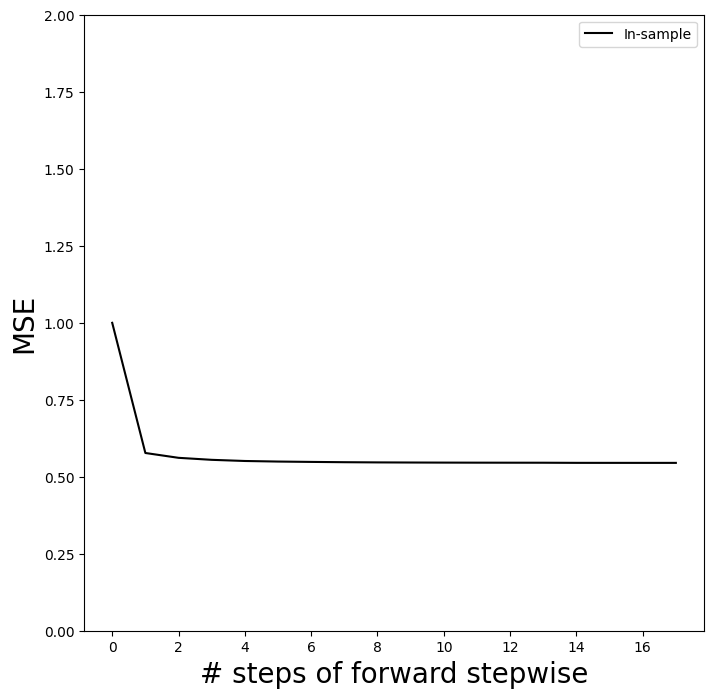

In [192]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([0, 2]);


Notice the expression `None` in `Y[:,None]` above.
This adds an axis (dimension) to the one-dimensional array `Y`,
which allows it to be recycled when subtracted from the two-dimensional `Yhat_in`.

We are now ready to use cross-validation to estimate test error along
the model path. We must use *only the training observations* to perform all aspects of model-fitting --- including
variable selection.  Therefore, the determination of which model of a
given size is best must be made using \emph{only the training
  observations} in each training fold. This point is subtle but important.  If the full data
set is used to select the best subset at each step, then the validation
set errors and cross-validation errors that we obtain will not be
accurate estimates of the test error.

We now compute the cross-validated predicted values using 5-fold cross-validation.

In [193]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                data,
                                Y,
                                cv=kfold)
Yhat_cv.shape


(3215, 18)

`skm.cross_val_predict()`
The prediction matrix `Yhat_cv` is the same shape as `Yhat_in`; the difference is that the predictions in each row, corresponding to a particular sample index, were made from models fit on a training fold that did not include that row.

At each model along the path, we compute the MSE in each of the cross-validation folds.
These we will average to get the  mean MSE, and can also use the individual values to compute a crude estimate of the standard error of the mean. {The estimate is crude because the five error estimates  are based on overlapping training sets, and hence are not independent.}
Hence we must know the test indices for each cross-validation
split. This can be found by using the `split()` method of `kfold`. Because
we  fixed the random state above, whenever we split any array with the same
number of rows as $Y$ we recover the same training and test indices, though we simply
ignore the training indices below.

In [194]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape


(18, 5)

We now add the cross-validation error estimates to our MSE plot.
We include the mean error across the five folds, and the estimate of the standard error of the mean.

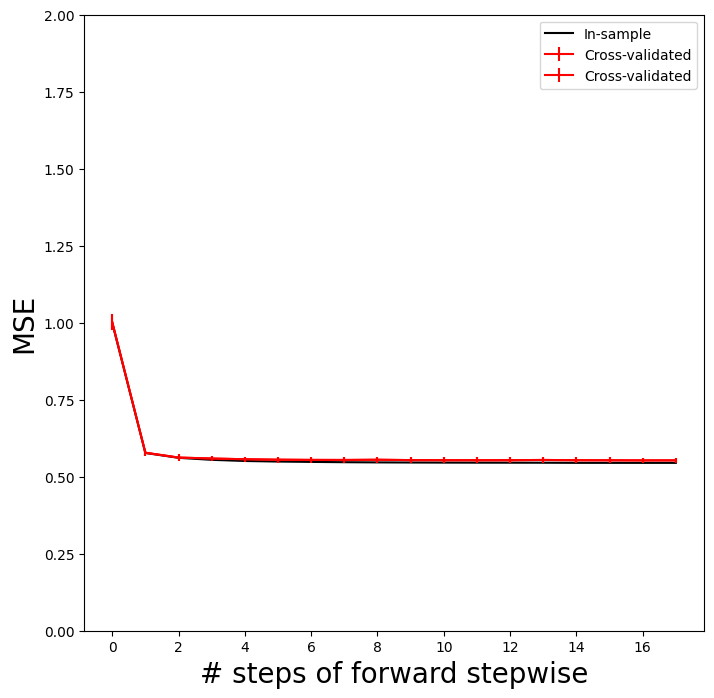

In [196]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
ax.set_ylim([0, 2])
ax.legend()
mse_fig


To repeat the above using the validation set approach, we simply change our
`cv` argument to a validation set: one random split of the data into a test and training. We choose a test size
of 20%, similar to the size of each test set in 5-fold cross-validation.`skm.ShuffleSplit()`

In [197]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.2,
                              random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(data.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(data.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx,None])**2
    validation_mse = errors.mean(0)


 As for the in-sample MSE case, the validation set approach does not provide standard errors.

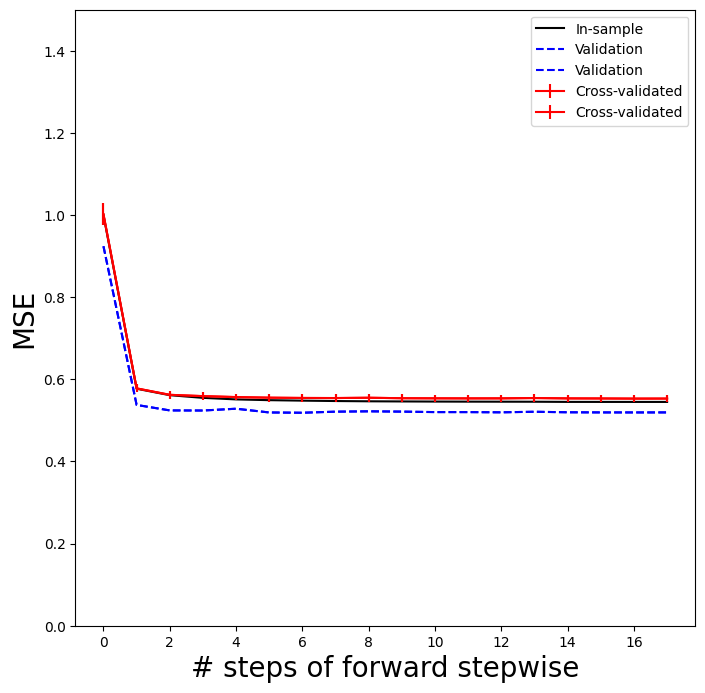

In [199]:
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([0, 1.5])
ax.legend()
mse_fig


## Ridge Regression and the Lasso
We will use the `sklearn.linear_model` package (for which
we use `skl` as shorthand below)
to fit ridge and  lasso regularized linear models on the `Hitters` data.
We start with the model matrix `X` (without an intercept) that we computed in the previous section on best subset regression.

### Ridge Regression
We will use the function `skl.ElasticNet()` to fit both  ridge and the lasso.
To fit a *path* of ridge regressions models, we use
`skl.ElasticNet.path()`, which can fit both ridge and lasso, as well as a hybrid mixture;  ridge regression
corresponds to `l1_ratio=0`.
It is good practice to standardize the columns of `X` in these applications, if the variables are measured in different units. Since `skl.ElasticNet()` does no normalization, we have to take care of that ourselves.
Since we
standardize first, in order to find coefficient
estimates on the original scale, we must *unstandardize*
the coefficient estimates. The parameter
$\lambda$ in (\ref{Ch6:ridge}) and (\ref{Ch6:LASSO}) is called `alphas` in `sklearn`. In order to
be consistent with the rest of this chapter, we use `lambdas`
rather than `alphas` in what follows.  {At the time of publication, ridge fits like the one in code chunk [22] issue unwarranted convergence warning messages; we expect these to disappear as this package matures.}

In [201]:
soln_array = skl.ElasticNet.path(X,
                                 Y,
                                 l1_ratio=0.,
                                 alphas = lambdas)[1]

c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.607e+03, tolerance: 3.214e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast

In [200]:
D = design.fit_transform(data)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [202]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs/ X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.607e+03, tolerance: 3.214e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast

(17, 100)

Here we extract the array of coefficients corresponding to the solutions along the regularization path.
By default the `skl.ElasticNet.path` method fits a path along
an automatically selected range of $\lambda$ values, except for the case when
`l1_ratio=0`, which results in ridge regression (as is the case here). {The reason is rather technical; for all models except ridge, we can find the smallest value of $\lambda$ for which all coefficients are zero. For ridge this value is $\infty$.}  So here
we have chosen to implement the function over a grid of values ranging
from $\lambda=10^{8}$ to $\lambda=10^{-2}$ scaled by the standard
deviation of $y$, essentially covering the full range of scenarios
from the null model containing only the intercept, to the least
squares fit.

Associated with each value of $\lambda$ is a vector of ridge
regression coefficients,   that can be accessed by
a column of `soln_array`. In this case, `soln_array` is a $19 \times 100$ matrix, with
19 rows (one for each predictor) and 100
columns (one for each value of $\lambda$).

We transpose this matrix and turn it into a data frame to facilitate viewing and plotting.

In [203]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path


age_s    dmarried_s       empl_06        age_lb  \
negative log(lambda)                                                           
-18.420836            2.339680e-10 -4.340817e-10  6.499921e-09  1.692631e-10   
-18.188252            2.952341e-10 -5.477490e-10  8.201970e-09  2.135858e-10   
-17.955668            3.725432e-10 -6.911808e-10  1.034971e-08  2.695148e-10   
-17.723083            4.700962e-10 -8.721713e-10  1.305986e-08  3.400891e-10   
-17.490499            5.931941e-10 -1.100555e-09  1.647967e-08  4.291437e-10   
...                            ...           ...           ...           ...   
 3.674677             4.098043e-02 -9.335531e-04  6.021951e-01 -4.498174e-02   
 3.907262             4.404385e-02 -8.440213e-04  6.054874e-01 -4.820431e-02   
 4.139846             4.680744e-02 -7.692519e-04  6.081263e-01 -5.109912e-02   
 4.372430             4.924883e-02 -7.071596e-04  6.102368e-01 -5.364812e-02   
 4.605015             5.136626e-02 -6.558977e-04  6.119218e-01 -5.585338e-02   

                       dmarried_lb       empl_04     salary_04     profit_04  \
negative log(lambda)                                                           
-18.420836           -6.728606e-10  1.748308e-09  2.187843e-09  9.597558e-13   
-18.188252           -8.490538e-10  2.206114e-09  2.760745e-09  1.211071e-12   
-17.955668           -1.071384e-09  2.783800e-09  3.483665e-09  1.528194e-12   
-17.723083           -1.351934e-09  3.512757e-09  4.395886e-09  1.928354e-12   
-17.490499           -1.705947e-09  4.432597e-09  5.546979e-09  2.433294e-12   
...                            ...           ...           ...           ...   
 3.674677            -7.140657e-03 -3.563538e-02  1.057146e-01 -2.205679e-02   
 3.907262            -7.062145e-03 -3.630943e-02  1.079343e-01 -2.224323e-02   
 4.139846            -7.000587e-03 -3.678624e-02  1.098184e-01 -2.240774e-02   
 4.372430            -6.952265e-03 -3.711396e-02  1.114001e-01 -2.255096e-02   
 4.605015            -6.914272e-03 -3.733288e-02  1.127151e-01 -2.267399e-02   

                           days_04      hours_04   contract_04    dformal_04  \
negative log(lambda)                                                           
-18.420836            1.829610e-09  1.856367e-09  1.530342e-09  1.590682e-09   
-18.188252            2.308706e-09  2.342469e-09  1.931073e-09  2.007213e-09   
-17.955668            2.913257e-09  2.955860e-09  2.436738e-09  2.532815e-09   
-17.723083            3.676113e-09  3.729873e-09  3.074814e-09  3.196050e-09   
-17.490499            4.638729e-09  4.706566e-09  3.879975e-09  4.032958e-09   
...                            ...           ...           ...           ...   
 3.674677            -1.323876e-02  4.543200e-02  2.929443e-02  2.671603e-02   
 3.907262            -1.432891e-02  4.686472e-02  2.916253e-02  2.655137e-02   
 4.139846            -1.530471e-02  4.809517e-02  2.904896e-02  2.641397e-02   
 4.372430            -1.616483e-02  4.913804e-02  2.895279e-02  2.630030e-02   
 4.605015            -1.691168e-02  5.001197e-02  2.887244e-02  2.620692e-02   

                           educ_lb        select      pempl_04        dwomen  \
negative log(lambda)                                                           
-18.420836            7.015580e-10  9.400337e-10  1.864934e-09 -2.069786e-09   
-18.188252            8.852658e-10  1.186188e-09  2.353280e-09 -2.611774e-09   
-17.955668            1.117079e-09  1.496800e-09  2.969502e-09 -3.295685e-09   
-17.723083            1.409593e-09  1.888747e-09  3.747087e-09 -4.158682e-09   
-17.490499            1.778705e-09  2.383328e-09  4.728287e-09 -5.247662e-09   
...                            ...           ...           ...           ...   
 3.674677             3.018972e-02  8.287420e-02 -2.046268e-02 -5.718033e-02   
 3.907262             3.017357e-02  8.391825e-02 -2.259718e-02 -5.615326e-02   
 4.139846             3.015976e-02  8.479029e-02 -2.444276e-02 -5.528133e-02   
 4.372430             3.01

We plot the paths to get a sense of how the coefficients vary with $\lambda$.
To control the location of the legend we first set `legend` to `False` in the
plot method, adding it afterward with the `legend()` method of `ax`.

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
C:\Users\narde\AppData\Local\Temp\ipykernel_38476\3549752342.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


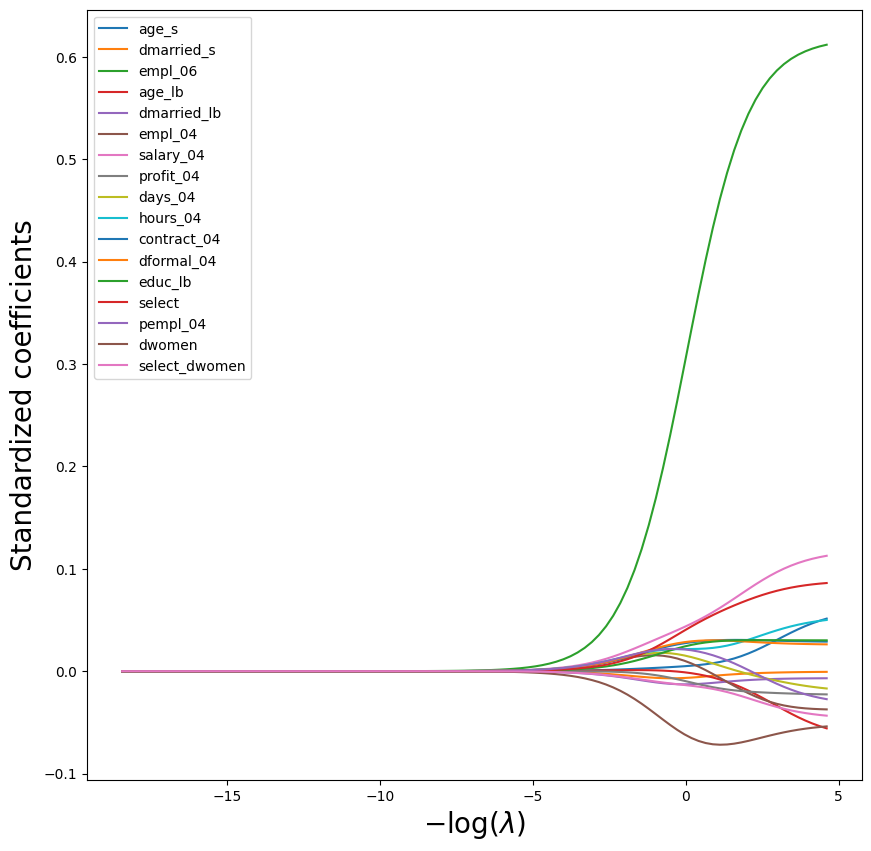

In [204]:
path_fig, ax = subplots(figsize=(10,10))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');


(We have used `latex` formatting in the horizontal label, in order to format the Greek $\lambda$ appropriately.)
We expect the coefficient estimates to be much smaller, in terms of
$\ell_2$ norm, when a large value of $\lambda$ is used, as compared to
when a small value of $\lambda$ is used. (Recall that the  $\ell_2$ norm is the square root of the sum of squared coefficient values.) We display  the coefficients at the $40$th step,
where $\lambda$ is 25.535.

In [205]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat


(np.float64(11499.35848474247),
 age_s            2.033981e-06
 dmarried_s      -3.774445e-06
 empl_06          5.652625e-05
 age_lb           1.471197e-06
 dmarried_lb     -5.850676e-06
 empl_04          1.519812e-05
 salary_04        1.902111e-05
 profit_04        7.638417e-09
 days_04          1.590514e-05
 hours_04         1.613802e-05
 contract_04      1.330491e-05
 dformal_04       1.382958e-05
 educ_lb          6.100964e-06
 select           8.174953e-06
 pempl_04         1.621270e-05
 dwomen          -1.799818e-05
 select_dwomen   -5.590884e-06
 Name: -9.350046528859922, dtype: float64)

Let’s compute the $\ell_2$ norm of the standardized coefficients.

In [206]:
np.linalg.norm(beta_hat)


np.float64(7.380084066121538e-05)

In contrast, here is the $\ell_2$ norm when $\lambda$ is 2.44e-01.
Note the much larger $\ell_2$ norm of the
coefficients associated with this smaller value of $\lambda$.

In [207]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)


(np.float64(109.76694894212099), np.float64(0.007552086080456667))

Above we normalized `X` upfront, and fit the ridge model using `Xs`.
The `Pipeline()`  object
in `sklearn` provides a clear way to separate feature
normalization from the fitting of the ridge model itself.

In [208]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e+03, tolerance: 3.214e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNet(alpha=np.float64(109.76694894212099), l1_ratio=0))])

We show that it gives the same $\ell_2$ norm as in our previous fit on the standardized data.

In [209]:
np.linalg.norm(ridge.coef_)


np.float64(0.007552086080456677)

 Notice that the operation `pipe.fit(X, Y)` above has changed the `ridge` object, and in particular has added attributes such as `coef_` that were not there before.
### Estimating Test Error of Ridge Regression
Choosing an *a priori* value of $\lambda$ for ridge regression is
difficult if not impossible. We will want to use the validation method
or cross-validation to select the tuning parameter. The reader may not
be surprised that the  `Pipeline()` approach can be used in
`skm.cross_validate()` with either a validation method
(i.e. `validation`) or $k$-fold cross-validation.

We fix the random state of the splitter
so that the results obtained will be reproducible.

In [210]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=0.5,
                              random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.352e+02, tolerance: 1.564e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([0.55878406])

The test MSE is 1.342e+05.  Note
that if we had instead simply fit a model with just an intercept, we
would have predicted each test observation using the mean of the
training observations. We can get the same result by fitting a ridge regression model
with a *very* large value of $\lambda$. Note that `1e10`
means $10^{10}$.

In [211]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge,
                             X,
                             Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.819e+02, tolerance: 1.564e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([1.0263211])

Obviously choosing $\lambda=0.01$ is arbitrary,  so we will  use cross-validation or the validation-set
approach to choose the tuning parameter $\lambda$.
The object `GridSearchCV()`  allows exhaustive
grid search to choose such a parameter.

We first use the validation set method
to choose $\lambda$.

In [212]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.819e+02, tolerance: 1.564e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.819e+02, tolerance: 1.564e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of th

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNet(alpha=np.float64(0.020095455533956783),
                            l1_ratio=0))])

Alternatively, we can use 5-fold cross-validation.

In [213]:
from sklearn.model_selection import RepeatedKFold
kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)


grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+03, tolerance: 2.578e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.316e+03, tolerance: 2.632e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of th

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNet(alpha=np.float64(0.020095455533956783),
                            l1_ratio=0))])

Recall we set up the `kfold` object for 5-fold cross-validation on page~\pageref{line:choos-among-models}. We now plot the cross-validated MSE as a function of $-\log(\lambda)$, which has shrinkage decreasing from left
to right.

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\narde\AppData\Local\Temp\ipykernel_38476\3735347934.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


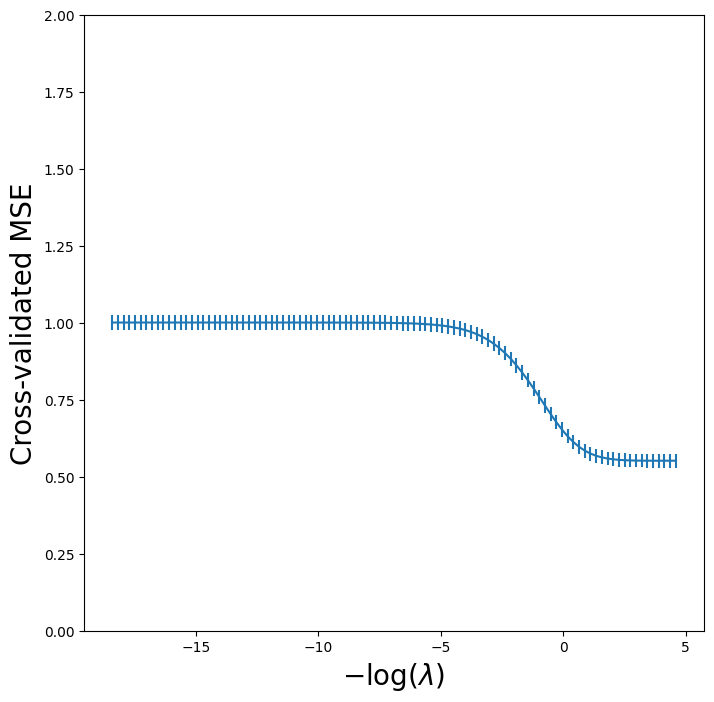

In [218]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([0, 2])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


One can cross-validate different metrics to choose a parameter. The default
metric for `skl.ElasticNet()` is test $R^2$.
Let’s compare $R^2$ to MSE for cross-validation here.

In [219]:
grid_r2 = skm.GridSearchCV(pipe,
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+03, tolerance: 2.578e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.316e+03, tolerance: 2.632e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of th

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([1.00015556e+08, 7.92606175e+07, 6.28126839e+07, 4.97779778e+07,
       3.94481961e+07, 3.12620208e+07, 2.47746168e+07, 1.96334602e+07,
       1.55591814e+07, 1.2...
       2.10523158e+00, 1.66836002e+00, 1.32214679e+00, 1.04777872e+00,
       8.30346715e-01, 6.58035571e-01, 5.21481936e-01, 4.13265516e-01,
       3.27505854e-01, 2.59542789e-01, 2.05683221e-01, 1.63000435e-01,
       1.29175057e-01, 1.02369024e-01, 8.11257008e-02, 6.42907305e-02,
       5.09493045e-02, 4.03764525e-02, 3.19976481e-02, 2.53575889e-02,
       2.00954555e-02, 1.59253048e-02, 1.26205317e-02, 1.00015556e-02])})

Finally, let’s plot the results for cross-validated $R^2$.

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
C:\Users\narde\AppData\Local\Temp\ipykernel_38476\537964502.py:5: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


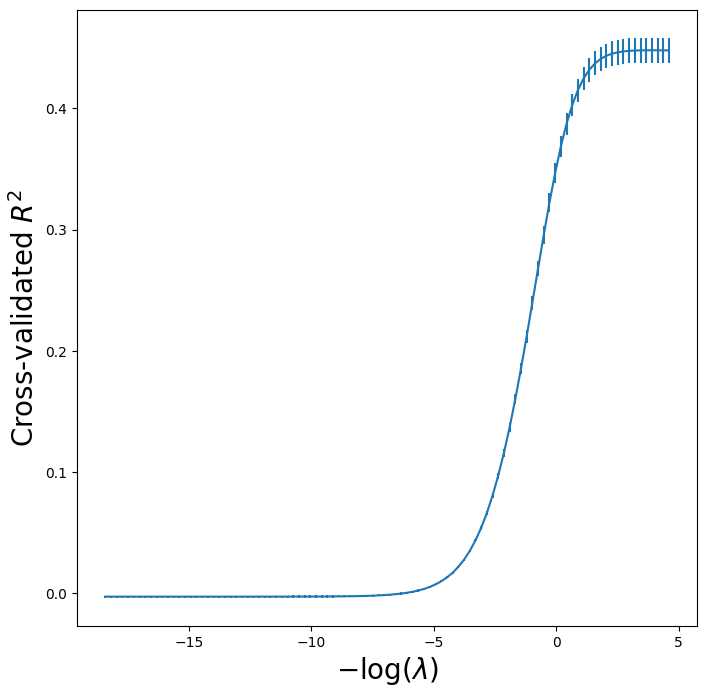

In [220]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);


### Fast Cross-Validation for Solution Paths
The ridge, lasso, and elastic net can be efficiently fit along a sequence of $\lambda$ values, creating what is known as a *solution path* or *regularization path*. Hence there is specialized code to fit
such paths, and to choose a suitable value of $\lambda$ using cross-validation. Even with
identical splits the results will not agree *exactly* with our `grid`
above because the standardization of each feature  in `grid` is carried out on each fold,
while in `pipeCV` below it is carried out only once.
Nevertheless, the results are similar as the normalization
is relatively stable across folds.

In [221]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+03, tolerance: 2.578e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([1.00015556e+08, 7.92606175e+07, 6.28126839e+07, 4.97779778e+07,
       3.94481961e+07, 3.12620208e+07, 2.47746168e+07, 1.96334602e+07,
       1.55591814e+07, 1.23303852e+07, 9.77161938e+06, 7.74384125e+06,
       6.13686176e+06, 4.86335799e+06, 3.85412804e+06, 3.05433056e+06,
       2.42050473e+06, 1.91820861e+06,...
       8.30346715e-01, 6.58035571e-01, 5.21481936e-01, 4.13265516e-01,
       3.27505854e-01, 2.59542789e-01, 2.05683221e-01, 1.63000435e-01,
       1.29175057e-01, 1.02369024e-01, 8.11257008e-02, 6.42907305e-02,
       5.09493045e-02, 4.03764525e-02, 3.19976481e-02, 2.53575889e-02,
       2.00954555e-02, 1.59253048e-02, 1.26205317e-02, 1.00015556e-02]),
                              cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=1),
                              l1_ratio=0))])

Let’s produce a plot again of the cross-validation error to see that
it is similar to using `skm.GridSearchCV`.

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\narde\AppData\Local\Temp\ipykernel_38476\2783861302.py:8: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


NameError: name 'k' is not defined

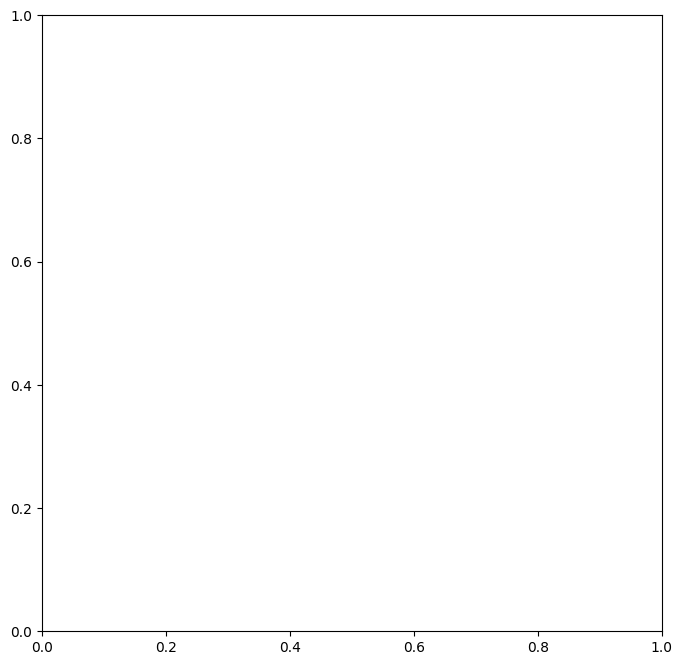

In [222]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(k))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


We see that the value of $\lambda$ that results in the
smallest cross-validation error is 1.19e-02, available
as the value `tuned_ridge.alpha_`. What is the test MSE
associated with this value of $\lambda$?

In [223]:
np.min(tuned_ridge.mse_path_.mean(1))


np.float64(0.5519325730567882)

This represents a further improvement over the test MSE that we got
using $\lambda=4$.  Finally, `tuned_ridge.coef_`
has the coefficients fit on the entire data set
at this value of  $\lambda$.

In [224]:
tuned_ridge.coef_


array([ 0.04404385, -0.00084402,  0.60548743, -0.04820431, -0.00706214,
       -0.03630943,  0.10793429, -0.02224323, -0.01432891,  0.04686472,
        0.02916253,  0.02655137,  0.03017357,  0.08391825, -0.02259718,
       -0.05615326, -0.04091591])

As expected, none of the coefficients are zero—ridge regression does
not perform variable selection!

### Evaluating Test Error of Cross-Validated Ridge
Choosing $\lambda$ using cross-validation provides a single regression
estimator, similar to fitting a linear regression model as we saw in
Chapter~\ref{Ch3:linreg}. It is therefore reasonable to estimate what its test error
is. We run into a problem here in that cross-validation will have
*touched* all of its data in choosing $\lambda$, hence we have no
further data to estimate test error. A compromise is to do an initial
split of the data into two disjoint sets: a training set and a test set.
We then fit a cross-validation
tuned ridge regression on the training set, and evaluate its performance on the test set.
We might call this cross-validation nested
within the validation set approach. A priori there is no reason to use
half of the data for each of the two sets in validation. Below, we use
75% for training and 25% for test, with the estimator being ridge
regression tuned using 5-fold cross-validation.  This can be achieved
in code as follows:

In [225]:
outer_valid = skm.ShuffleSplit(n_splits=1,
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);


In [226]:
results = skm.cross_validate(pipeCV,
                             X,
                             Y,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.358e+02, tolerance: 1.872e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast

array([0.56482872])

### The Lasso
We saw that ridge regression with a wise choice of $\lambda$ can
outperform least squares as well as the null model on the
 `Hitters`  data set. We now ask whether the lasso can yield
either a more accurate or a more interpretable model than ridge
regression. In order to fit a lasso model, we once again use the
`ElasticNetCV()`  function; however, this time we use the argument
`l1_ratio=1`. Other than that change, we proceed just as we did in
fitting a ridge model.

In [227]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


c:\Users\narde\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


np.float64(0.004917716943766215)

In [228]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))


We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\narde\AppData\Local\Temp\ipykernel_38476\163252521.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


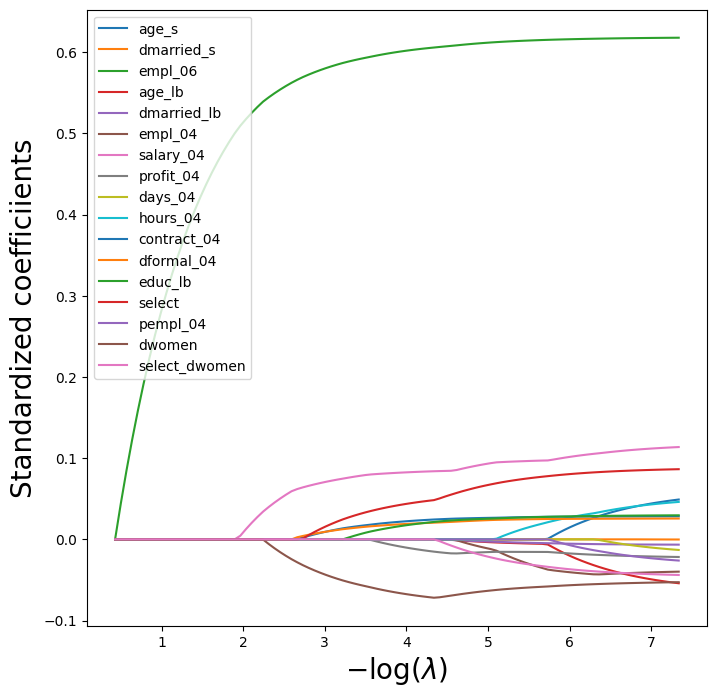

In [229]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


The smallest cross-validated error is lower than the test set MSE of the null model
and of least squares, and very similar to the test MSE of 115526.71 of ridge
regression (page~\pageref{page:MSECVRidge}) with $\lambda$ chosen by cross-validation.

In [230]:
np.min(tuned_lasso.mse_path_.mean(1))


np.float64(0.5516764219930163)

Let’s again produce a plot of the cross-validation error.


<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
C:\Users\narde\AppData\Local\Temp\ipykernel_38476\2121041475.py:7: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


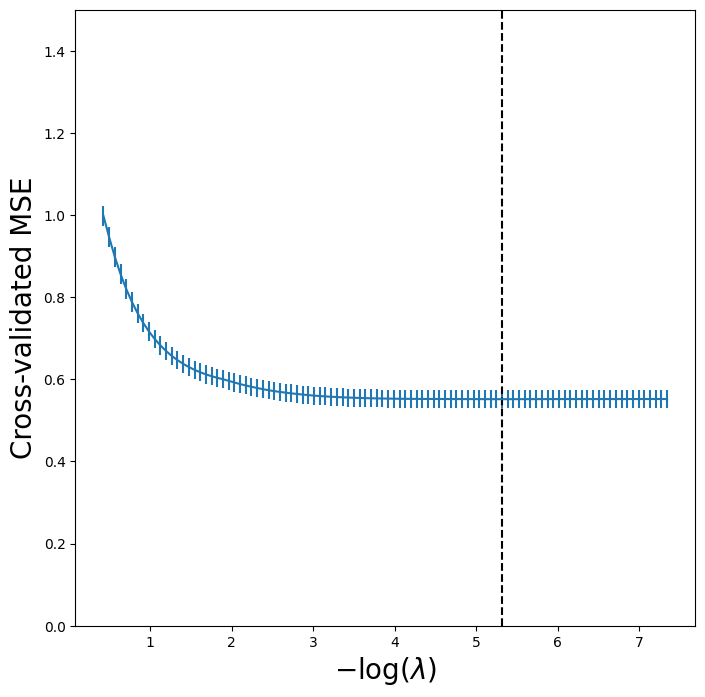

In [233]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0, 1.5])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

However, the lasso has a substantial advantage over ridge regression
in that the resulting coefficient estimates are sparse. Here we see
that 6 of the 19 coefficient estimates are exactly zero. So the lasso
model with $\lambda$ chosen by cross-validation contains only 13
variables.

In [234]:
tuned_lasso.coef_


array([ 0.        , -0.        ,  0.61352535, -0.00457591, -0.00373295,
       -0.02356803,  0.09564912, -0.0154788 , -0.        ,  0.0092709 ,
        0.02714569,  0.02447472,  0.02659501,  0.07268308, -0.        ,
       -0.06051985, -0.02788255])

As in ridge regression, we could evaluate the test error
of cross-validated lasso by first splitting into
test and training sets and internally running
cross-validation on the training set. We leave
this as an exercise.

## PCR and PLS Regression

### Principal Components Regression

Principal components regression (PCR) can be performed using
`PCA()`  from the `sklearn.decomposition`
module. We now apply PCR to the  `Hitters`  data, in order to
predict `Salary`. Again, ensure that the missing values have
been removed from the data, as described in Section~\ref{Ch6-varselect-lab:lab-1-subset-selection-methods}.

We use `LinearRegression()`  to fit the regression model
here. Note that it fits an intercept by default, unlike
the `OLS()` function seen earlier in Section~\ref{Ch6-varselect-lab:lab-1-subset-selection-methods}.

In [130]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_


array([0.09846131, 0.4758765 ])

When performing PCA, the results vary depending
on whether the data has been *standardized* or not.
As in the earlier examples, this can be accomplished
by including an additional step in the pipeline.

In [131]:
pipe = Pipeline([('scaler', scaler),
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_


array([106.36859204,  21.60350456])

We can of course use CV to choose the number of components, by
using `skm.GridSearchCV`, in this
case fixing the parameters to vary the
`n_components`.

In [132]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

Let’s plot the results as we have for other methods.

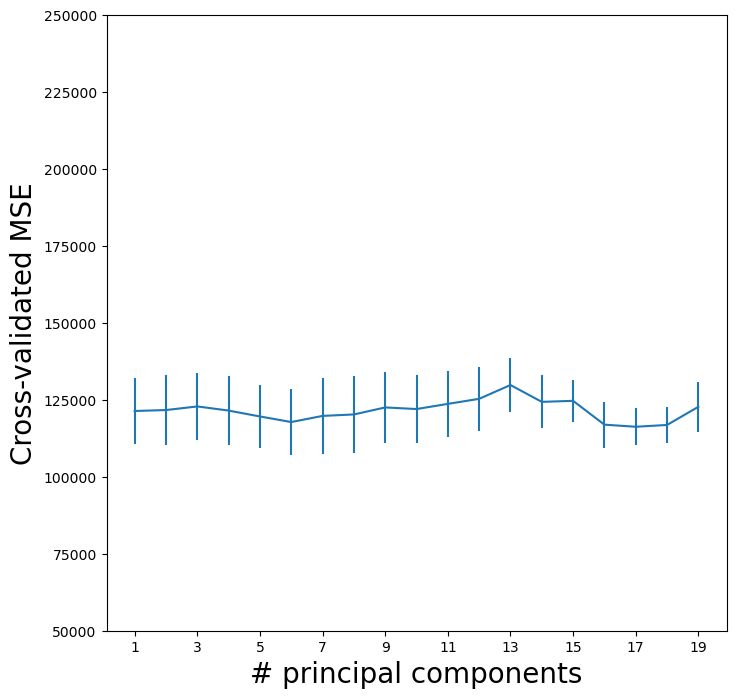

In [133]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);


We see that the smallest cross-validation error occurs when
17
components are used. However, from the plot we also see that the
cross-validation error is roughly the same when only one component is
included in the model. This suggests that a model that uses just a
small number of components might suffice.

The CV score is provided for each possible number of components from
1 to 19 inclusive. The `PCA()` method complains
if we try to fit an intercept only with `n_components=0`
so we also compute the MSE for just the null model with
these splits.

In [134]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()


np.float64(204139.30692994667)

The `explained_variance_ratio_`
attribute of our `PCA` object provides the *percentage of variance explained* in the predictors and in the response using
different numbers of components. This concept is discussed in greater
detail in Section~\ref{Ch10:sec:pca}.

In [135]:
pipe.named_steps['pca'].explained_variance_ratio_


array([0.3831424 , 0.21841076])

Briefly, we can think of
this as the amount of information about the predictors
that is captured using $M$ principal components. For example, setting
$M=1$ only captures 38.31% of the variance, while $M=2$ captures an additional 21.84%, for a total of 60.15% of the variance.
By  $M=6$ it increases to
88.63%. Beyond this the increments continue to diminish, until we use all $M=p=19$ components, which captures all  100% of the variance.



### Partial Least Squares
Partial least squares (PLS) is implemented in the
`PLSRegression()`  function.



In [136]:
pls = PLSRegression(n_components=2,
                    scale=True)
pls.fit(X, Y)


PLSRegression()

As was the case in PCR, we will want to
use CV to choose the number of components.

In [137]:
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

As for our other methods, we plot the MSE.

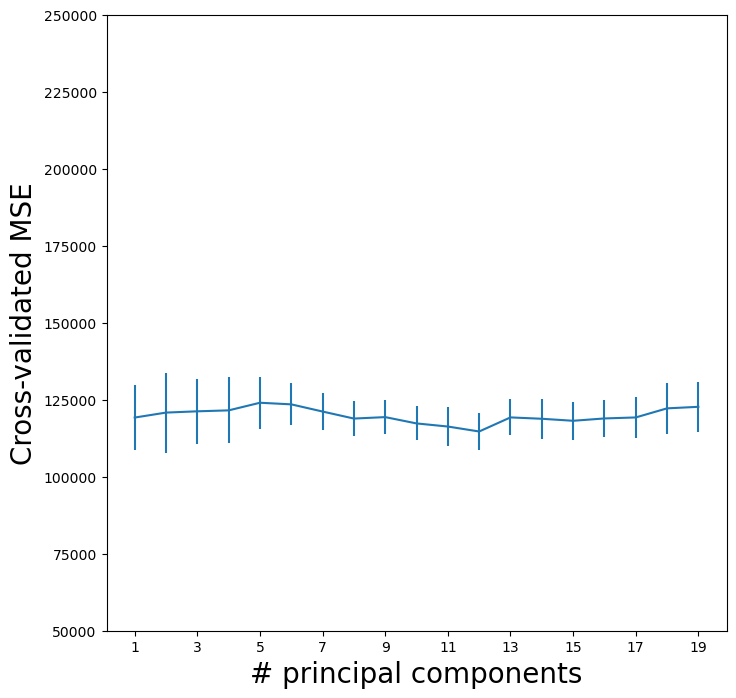

In [138]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000]);


CV error is minimized at 12,
though there is little noticable difference between this point and a much lower number like 2 or 3 components.

